# Functional urban area (FUAs) projection

Project central european functional urban areas onto 2 PCA components, based on the distribution of urban fabric types within each FUA.

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

v = 'v10'

target_countries = ['DEU', 'CZE', 'AUT', 'POL', 'SVK']
regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')
mapping = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq"
)

In [7]:
fuas = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
fuas = fuas[fuas.Cntry_ISO.isin(target_countries)]
fuas = fuas.to_crs(epsg=3035)

In [8]:
# fuas.explore()

Assign a FUA identifier for every building.

In [9]:
%%time

results = []

for region_id in regions.index:
    
    region_buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')
    
    # assign polygons to only one fua
    inp, res = region_buildings.sindex.query(fuas.geometry, predicate='intersects')
    # polygons should be assigned to only one fua
    duplicated = pd.Series(res).duplicated()
    inp = inp[~duplicated]
    res = res[~duplicated]
    
    # keep only fua buildings and record  fua 'country', 'city', 'population'
    region_buildings = region_buildings.iloc[res]
    region_buildings.loc[:, ['city', 'country', 'population']] = fuas.iloc[inp, [3, 5, 9]].values

    results.append(region_buildings)

all_fua_buildings = pd.concat(results, ignore_index=True)

CPU times: user 1min 48s, sys: 8.37 s, total: 1min 57s
Wall time: 1min 47s


In [10]:
all_fua_buildings.head()

,currentUse,buildingNature,heightAboveGround,iid,geometry,label,morph,final,final_without_noise,city,...,beginLifespanVersion,conditionOfConstruction,localId,namespace,versionId,referenceGeometry,horizontalGeometryEstimatedAccuracy,x,y,id
0,Nach Quellenlage nicht zu spezifizieren,Gebäude,NaN,28283100,"POLYGON ((4084658.933 3111002.372, 4084660.633...",29677,4_2427_1,102,102,Mönchengladbach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Schuppen,Gebäude,NaN,37719199,"POLYGON ((4084690.442 3111047.559, 4084691.964...",29677,4_2427_1,102,102,Mönchengladbach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wohnhaus,Gebäude,NaN,37719200,"POLYGON ((4084677.785 3111047.165, 4084682.222...",29677,4_2427_1,102,102,Mönchengladbach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nach Quellenlage nicht zu spezifizieren,Gebäude,NaN,28283081,"POLYGON ((4084670.573 3111046.746, 4084674.818...",29677,4_2427_1,102,102,Mönchengladbach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Carport,Sonstiges Bauwerk oder sonstige Einrichtung,NaN,32590234,"POLYGON ((4084688.661 3111052.389, 4084690.753...",29677,4_2427_1,102,102,Mönchengladbach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# all_fua_buildings.iloc[:1000].explore()

Assign cluster identifiers at a specified level for every building,  aggregate the building data to functional areas, calculate the distribution of urban fabric clusters and compute the principle components.

In [46]:
def generate_pca_plot_at_level(building_data, level, by_area=False):
    """Generate a PCA dataframe from a building data frame"""
    
    # Assign cluster identifiers at a specified level for every building
    if by_area:
        subset = all_fua_buildings[['country', 'city', 'final_without_noise', 'geometry']]
        subset = subset[subset.city != 'Lubin']
    else:
        subset = building_data[['country', 'city', 'final_without_noise']]
    
    if level < 7:
        subset.loc[:, 'final_without_noise'] = subset.final_without_noise.map(mapping[level].to_dict())

    # aggregate the building data to functional areas
    if by_area:
        res = subset.groupby(['country', 'city', 'final_without_noise'])['geometry'].apply(lambda x: x.area.sum())
        res = res.unstack(-1).fillna(0)
    else:
        res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
        res = res.unstack(-1).fillna(0).astype(int)
    
    # normalise based on counts
    # note: normalisation can be based on building area too
    X = res.values / res.sum(axis=1).values[:, np.newaxis]

    # compute the PCs and return the results
    pca = PCA(n_components=3)
    components = pca.fit_transform(X)
    print(pca.explained_variance_, pca.explained_variance_ratio_)
    
    df = pd.DataFrame(components, columns=['PC1', 'PC2', 'PC3'])
    df.loc[:, 'city'] = res.index.get_level_values(1).values
    df.loc[:, 'country'] = res.index.get_level_values(0).values
    return df

[0.0078353  0.00130423 0.0011289 ] [0.37800321 0.06292091 0.05446202]
[0.01797811 0.00321962 0.00289096] [0.49046442 0.0878351  0.07886872]
[0.0318229  0.00627041 0.00327529] [0.62645878 0.12343798 0.06447675]
[0.03818901 0.00639199 0.00335169] [0.69351584 0.11607903 0.06086703]
[0.05562636 0.00865512 0.00299316] [0.81197129 0.12633781 0.04369085]
[0.07188796 0.00151996 0.        ] [0.97929438 0.02070562 0.        ]


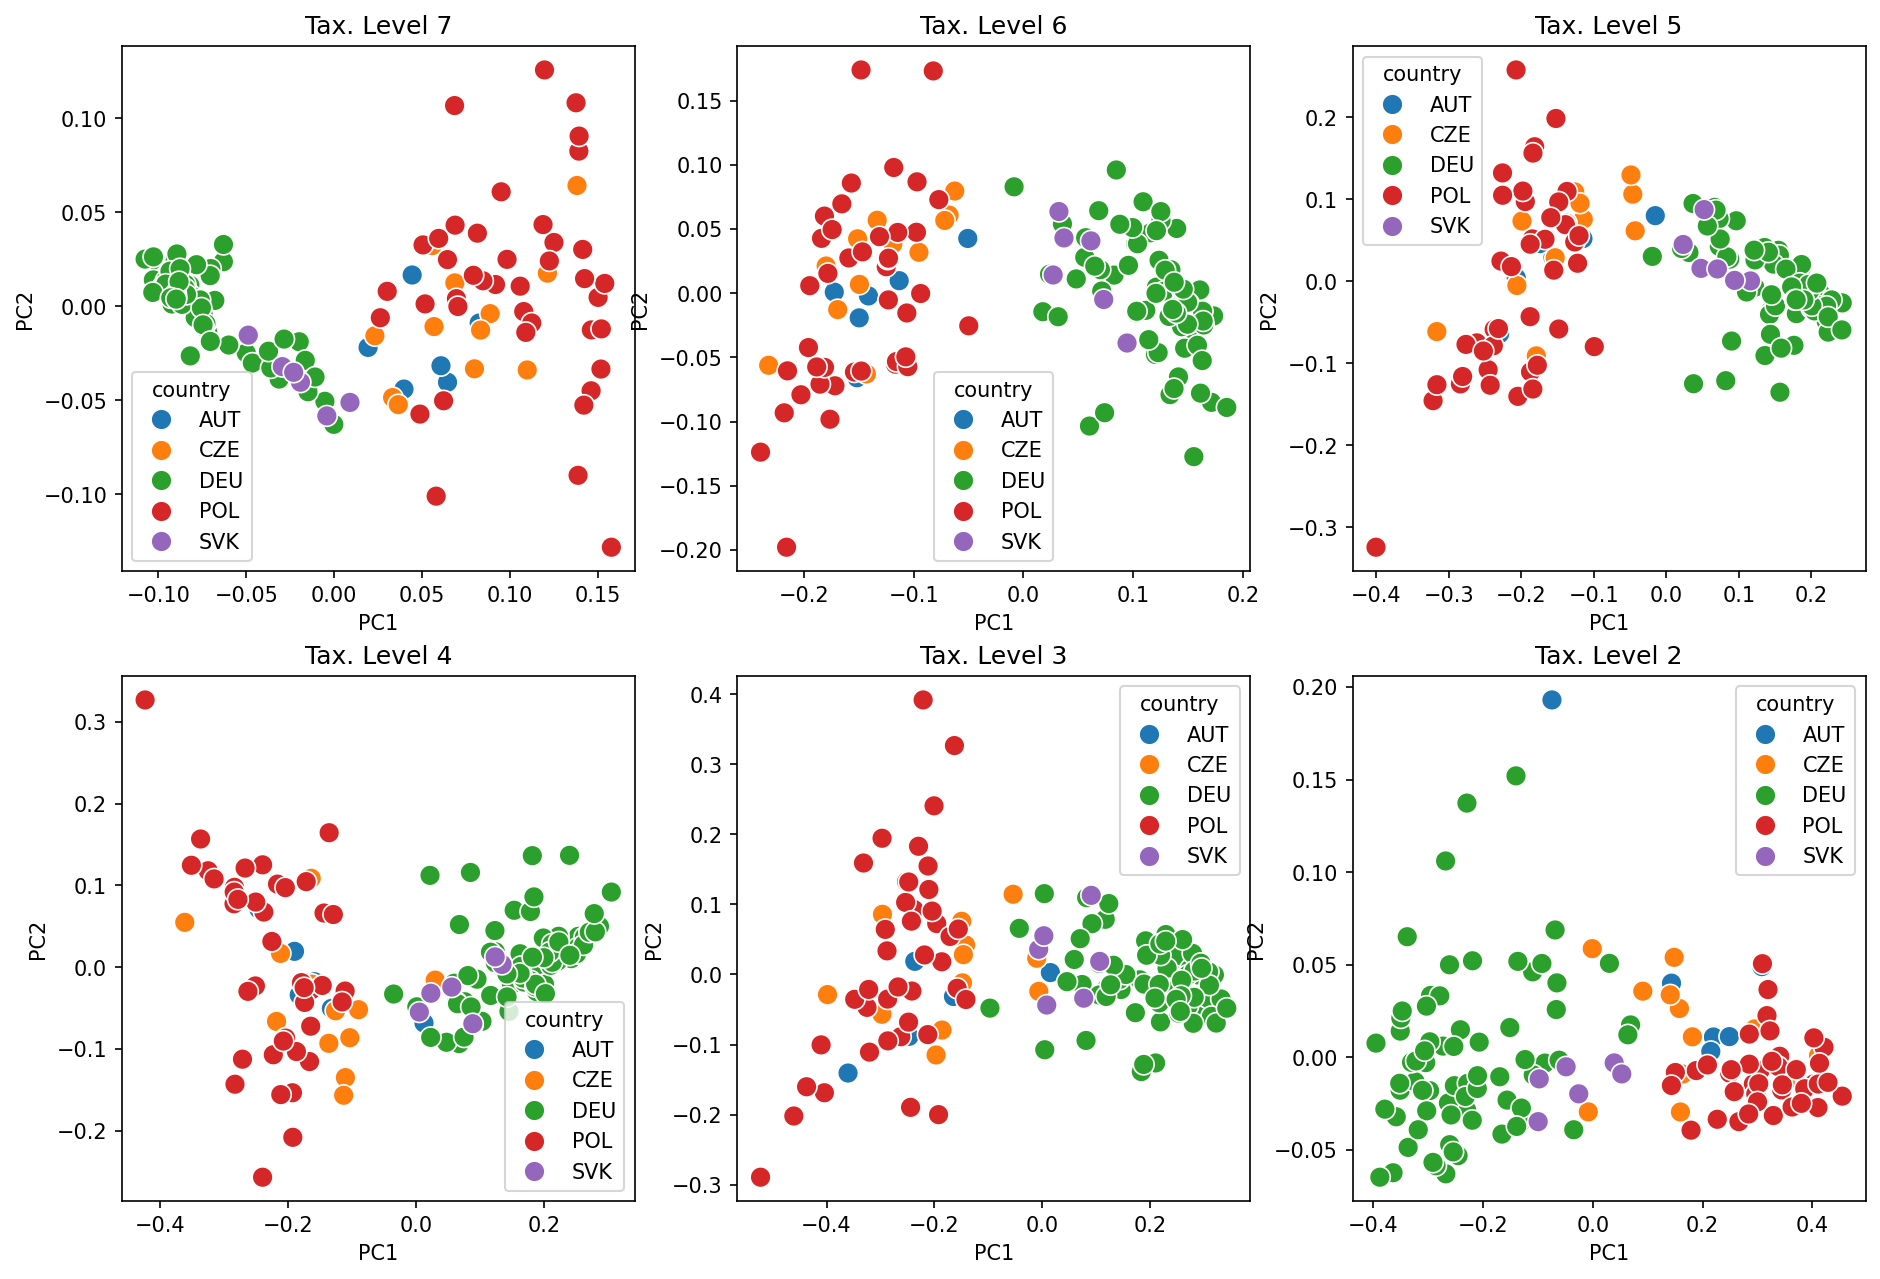

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=150)

for level, ax in zip(range(7, 1, -1), axes.flatten()):
    df = generate_pca_plot_at_level(all_fua_buildings, level, by_area=True)
    sns.scatterplot(x="PC1", y="PC2", hue='country', data=df, s=100, ax=ax)
    ax.set_title(f'Tax. Level {level}')

Assign a geometry, to try out different coloring schemes based on political boundaries.

In [48]:

level=7
df = generate_pca_plot_at_level(all_fua_buildings, level, by_area=True)
# assign a geometry
gdf_fuas = gpd.GeoDataFrame(df, geometry=fuas.set_index('eFUA_name').loc[df['city'].values, 'geometry'].values)

[0.0078353  0.00130423 0.0011289 ] [0.37800321 0.06292091 0.05446202]


In [49]:
# read boundaries
layer_names = gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name.values.tolist()

In [50]:
layer_names.remove('1300_ostsiedlung')
layer_names.remove('1900_germans')

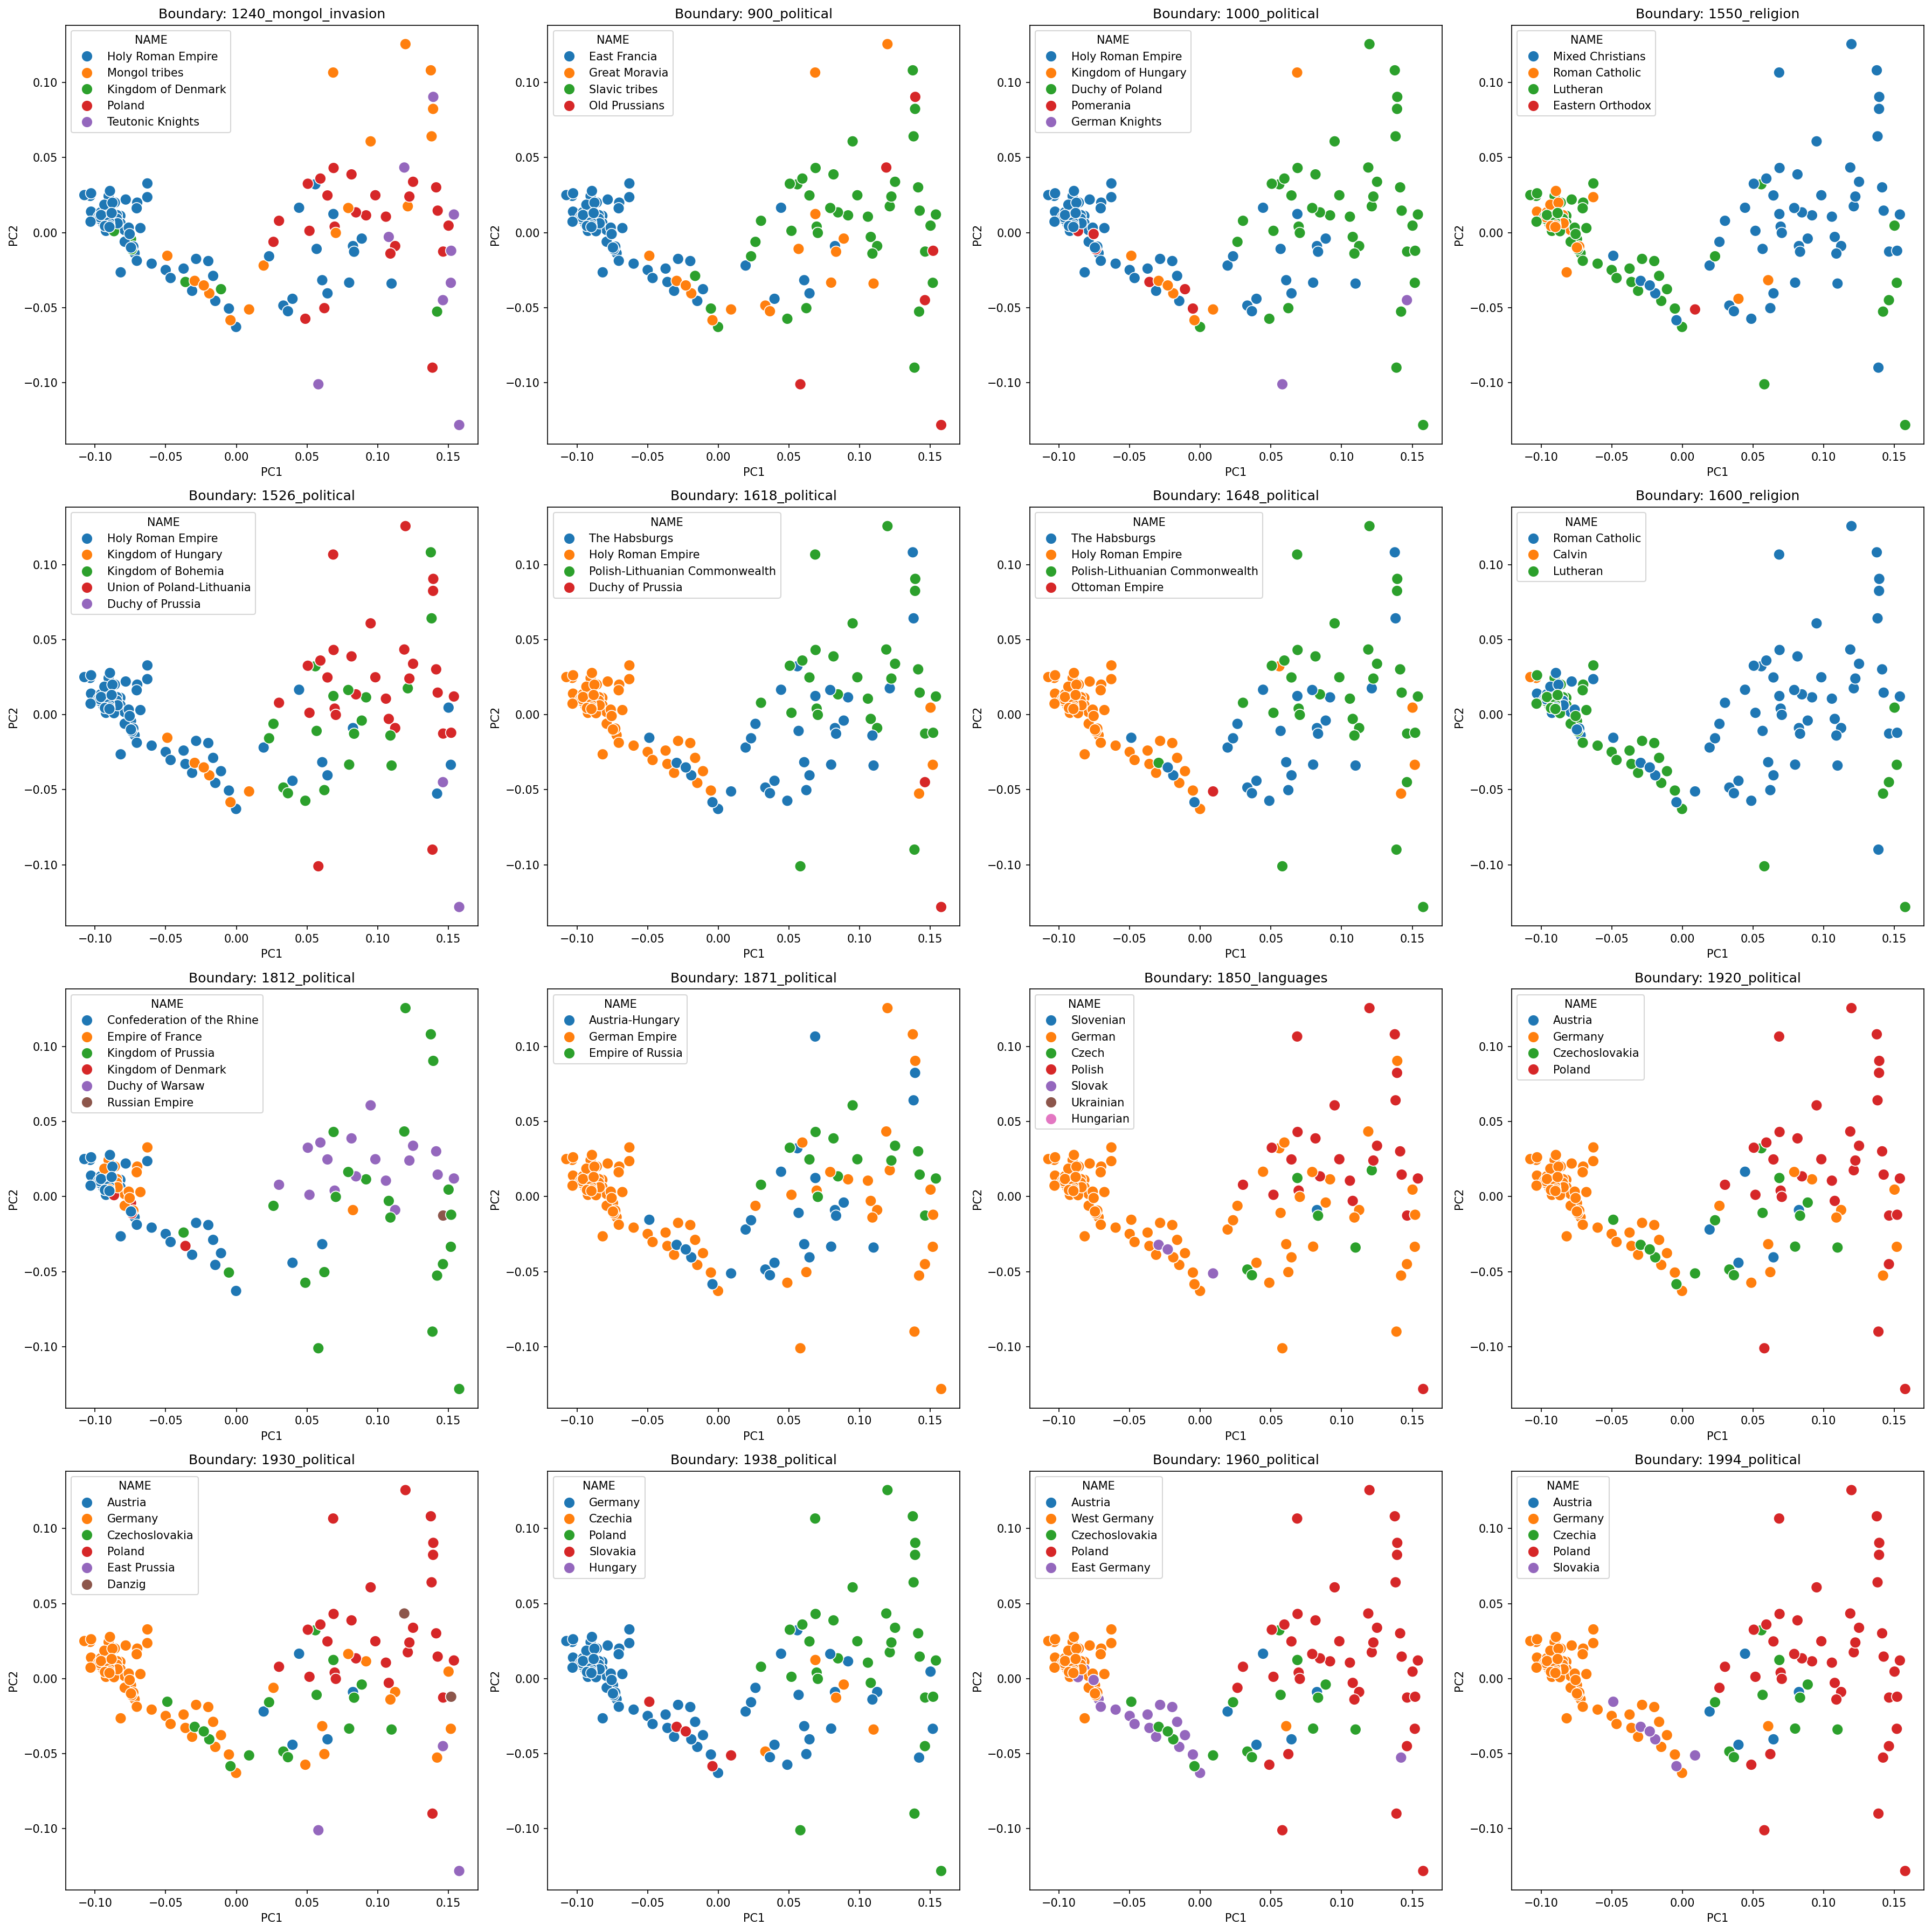

In [51]:
fig, axes = plt.subplots(4, 4, figsize=(24, 24), dpi=150)

for layer, ax in zip(layer_names, axes.flatten()):

    boundaries = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg', layer=layer)
    new_df = gdf_fuas.sjoin(boundaries)
    sns.scatterplot(x="PC1", y="PC2", hue='NAME', data=new_df, s=100, ax=ax)
    ax.set_title(f'Boundary: {layer}')

fig.tight_layout()

In [ ]:
import jscatter
scatter = jscatter.Scatter(data=new_df, x='PC1', y='PC2', color_by='NAME', tooltip=True, tooltip_properties=["city", "NAME"], size=10)
scatter.background('#1E1E20')

scatter.show()

Direct compariosns between cities

In [102]:
# Assign cluster identifiers at a specified level for every building 
subset = all_fua_buildings[['country', 'city', 'final_without_noise']]
if level < 7:
    subset.loc[:, 'final_without_noise'] = subset.final_without_noise.map(mapping[level].to_dict())

# aggregate the building data to functional areas
res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
res = res.unstack(-1).fillna(0).astype(int)

# aggregate the building data to functional areas
res_area = all_fua_buildings[['country', 'city', 'final_without_noise', 'geometry']].groupby(['country', 'city', 'final_without_noise'])['geometry'].apply(lambda x: x.area.sum())
res_area = res_area.unstack(-1).fillna(0).reset_index(0, drop=True)

# normalise based on counts
# note: normalisation can be based on building area too
# X = res.values / res.sum(axis=1).values[:, np.newaxis]

In [38]:
res = all_fua_buildings[['country', 'city', 'final_without_noise', 'geometry']].groupby(['country', 'city', 'final_without_noise'])['geometry'].apply(lambda x: x.area.sum())
res = res.unstack(-1).fillna(0)

In [40]:
X = res.values / res.sum(axis=1).values[:, np.newaxis]

In [41]:
X

array([[0.01664659, 0.01424746, 0.04524566, ..., 0.        , 0.        ,
        0.        ],
       [0.04694735, 0.00937668, 0.08197364, ..., 0.00654247, 0.00064515,
        0.00337311],
       [0.0496665 , 0.01659346, 0.06508995, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04825978, 0.10183168, 0.01730144, ..., 0.00201204, 0.00087408,
        0.        ],
       [0.04534629, 0.02013443, 0.02552308, ..., 0.00742939, 0.00630462,
        0.00408423],
       [0.0329425 , 0.04559159, 0.01585073, ..., 0.01098209, 0.00246621,
        0.00216554]], shape=(136, 110))

In [117]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)

In [119]:
pca.explained_variance_ratio_

array([0.2833594 , 0.17213349, 0.06974293])

In [103]:
X = res_area.values / res_area.sum(axis=1).values[:, np.newaxis]

In [108]:
X = pd.DataFrame(X, index=res_area.index, columns=res_area.columns)
X.name = ''
X

final_without_noise,1,2,3,4,5,6,7,8,9,10,...,95,96,97,98,99,100,101,102,103,104
city,,,,,,,,,,,,,,,,,,,,,
Graz,0.002861,0.052248,0.026914,0.001932,0.010037,0.020076,0.006803,0.012584,0.000000,0.001994,...,0.001046,0.000677,0.000259,0.010146,0.005920,0.003634,0.014342,0.000178,0.000000,0.000093
Innsbruck,0.020444,0.095256,0.040264,0.000000,0.020022,0.033304,0.000000,0.027987,0.000000,0.000000,...,0.002329,0.002613,0.000000,0.005415,0.008683,0.000568,0.035348,0.000000,0.003373,0.000000
Klagenfurt,0.019093,0.085887,0.067040,0.000291,0.027973,0.005362,0.001558,0.005618,0.000000,0.000000,...,0.000276,0.000000,0.000000,0.009849,0.000000,0.005705,0.022042,0.000000,0.000000,0.000086
Linz,0.028240,0.082764,0.046404,0.000000,0.017685,0.022825,0.003291,0.011564,0.000000,0.000423,...,0.000953,0.000399,0.000607,0.010011,0.006350,0.003296,0.017508,0.000040,0.000000,0.000000
Salzburg,0.021247,0.116064,0.055157,0.000165,0.025394,0.016106,0.005133,0.025533,0.000000,0.000000,...,0.001225,0.002271,0.000000,0.006366,0.000000,0.002180,0.029999,0.000000,0.000637,0.000052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bratislava,0.018428,0.088123,0.036662,0.031262,0.019454,0.014865,0.005441,0.017887,0.000000,0.055913,...,0.001791,0.000185,0.001488,0.011704,0.011400,0.001842,0.007365,0.001418,0.004547,0.005858
Košice,0.024888,0.118593,0.027492,0.014341,0.006364,0.013541,0.004678,0.009527,0.023623,0.005647,...,0.002518,0.000000,0.000000,0.004629,0.001735,0.002266,0.002918,0.000274,0.000026,0.001505
Prešov,0.023247,0.095203,0.015415,0.044370,0.015544,0.042786,0.003081,0.003456,0.000000,0.001543,...,0.002656,0.000000,0.000000,0.003930,0.005796,0.000000,0.002447,0.000000,0.000000,0.004434


In [109]:
from sklearn.neighbors import KDTree

In [110]:
tree = KDTree(X)
dists, nns = tree.query(X.values, k=10)

In [111]:
X.index[nns[-1:, 1:].flatten()]

Index(['Gera', 'Chemnitz', 'Kassel', 'Bratislava', 'Ulm', 'Brunswick',
       'Kaiserslautern', 'Prešov', 'Lüneburg'],
      dtype='object', name='city')

In [112]:
X.loc[['Žilina', 'Chemnitz', 'Jena']].style.background_gradient(axis=0, cmap="BuGn")

final_without_noise,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Žilina,0.021581,0.014700,0.028111,0.055776,0.024420,0.023279,0.006765,0.007253,0.000000,0.031021,0.000000,0.032762,0.016822,0.030571,0.000000,0.015249,0.000177,0.004042,0.002665,0.001372,0.010535,0.000110,0.001865,0.003831,0.008053,0.002098,0.003291,0.000000,0.000000,0.000000,0.002830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008163,0.006182,0.004220,0.018367,0.000371,0.041004,0.006048,0.015445,0.012984,0.011485,0.002104,0.025694,0.000000,0.000000,0.004303,0.002118,0.003626,0.007297,0.003935,0.025065,0.030393,0.000000,0.000263,0.005122,0.043563,0.024445,0.028645,0.069293,0.037743,0.007421,0.021803,0.000000,0.006424,0.006371,0.000000,0.002654,0.013206,0.021029,0.015038,0.020988,0.011269,0.001899,0.002418,0.023365,0.021072,0.000522,0.005349,0.000000,0.000000,0.010664,0.008927,0.000582,0.003371,0.001578,0.001436,0.005562
Chemnitz,0.014465,0.020447,0.068363,0.021437,0.017499,0.008471,0.012432,0.021173,0.000000,0.003969,0.000000,0.030133,0.042408,0.008629,0.000000,0.003278,0.000612,0.004484,0.006313,0.009394,0.013070,0.004072,0.007479,0.008111,0.007675,0.003269,0.003989,0.000033,0.000699,0.000000,0.000587,0.000000,0.000312,0.000000,0.000000,0.000000,0.000000,0.000000,0.001302,0.000559,0.000286,0.000000,0.000000,0.000000,0.000000,0.000003,0.000735,0.016943,0.018970,0.001060,0.047036,0.001090,0.024625,0.006805,0.016639,0.043331,0.013578,0.013264,0.027081,0.000000,0.000370,0.006212,0.002585,0.000000,0.001837,0.011953,0.049658,0.041601,0.000000,0.000000,0.011726,0.041126,0.007213,0.008739,0.024661,0.033292,0.004467,0.035790,0.000595,0.003841,0.005458,0.000000,0.000000,0.008635,0.004346,0.007322,0.003824,0.000651,0.002037,0.003945,0.004147,0.028897,0.001254,0.003443,0.001270,0.000274,0.028327,0.022214,0.002565,0.004146,0.001961,0.001267,0.002240
Jena,0.011525,0.068454,0.023965,0.021822,0.042309,0.050379,0.009420,0.005114,0.000000,0.000000,0.000000,0.041764,0.019186,0.004105,0.000000,0.000000,0.007615,0.001082,0.001613,0.002656,0.007643,0.001594,0.007531,0.012817,0.002177,0.004021,0.000000,0.000000,0.000000,0.000000,0.000171,0.000965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004020,0.000000,0.000000,0.000000,0.000000,0.000067,0.002709,0.012179,0.000000,0.000000,0.009324,0.000000,0.011270,0.000319,0.000206,0.002119,0.003258,0.000000,0.006432,0.000000,0.001698,0.010247,0.013758,0.001237,0.037066,0.008488,0.025138,0.016673,0.000015,0.000000,0.017162,0.033653,0.019651,0.030918,0.040316,0.025551,0.006594,0.024108,0.000399,0.012357,0.008032,0.000000,0.005632,0.010670,0.015770,0.012409,0.020215,0.010574,0.009845,0.006978,0.037698,0.009693,0.003417,0.000610,0.002296,0.000000,0.009145,0.021160,0.000000,0.013146,0.022793,0.006557,0.048498


Assign population to a PCA dataframe

In [39]:

level=7
df = generate_pca_plot_at_level(all_fua_buildings, level)
population = fuas.set_index('eFUA_name').loc[df['city'].values, 'FUA_p_2015'].values
df['population'] = population

[0.01710804 0.00593765 0.00471977] [0.31507762 0.10935323 0.08692371]


In [36]:
df[df['city'] == 'Lubin']

,PC1,PC2,PC3,city,country
108,0.011112,0.751149,0.000117,Lubin,POL


Assign pca distance to every FUA. The `pca distance sums` is the sum of distances in PCA space, between a FUA and its 5 closest geographical neighbours.
The value is higher, for those FUA that are further away from their 5 closest geographical neighbours.

In [40]:
from libpysal.graph import Graph
from scipy.spatial.distance import cdist

In [41]:
pca_df = df[['PC1', 'PC2', 'city']].set_index('city')

city_centroids = fuas.set_index('eFUA_name').loc[df['city'].values, 'geometry'].centroid
spatial_graph = Graph.build_kernel(city_centroids, kernel='identity', k=5)

pca_distance_sums = {}
for focal, neighbours in spatial_graph.adjacency.groupby(level=0):
    neighbours = neighbours.index.get_level_values(1).values
    pca_distance_sum = cdist(pca_df.loc[[focal]].values, pca_df.loc[neighbours].values)[0].sum()
    pca_distance_sums[focal] = pca_distance_sum

df['pca_distance_sums'] = (pd.Series(pca_distance_sums) * 1_000).loc[df.city].values

<Axes: xlabel='PC1', ylabel='PC2'>

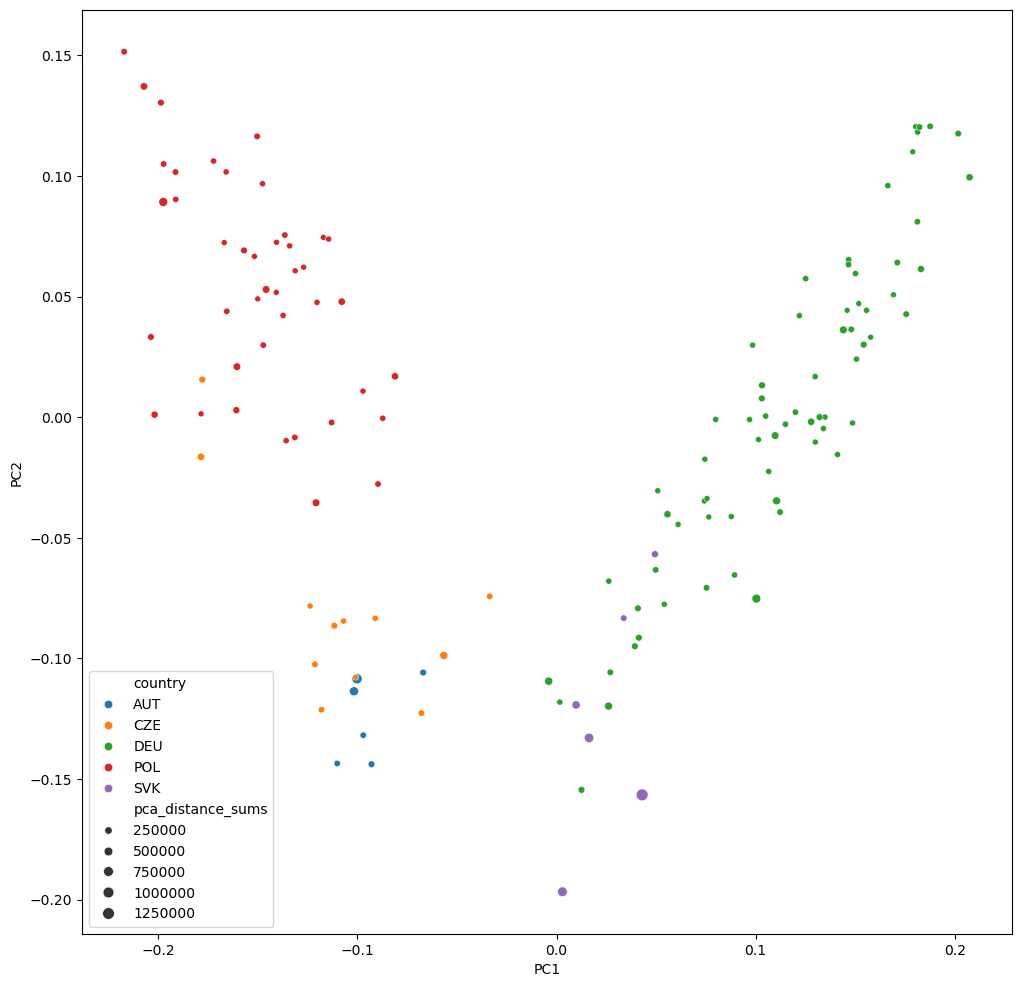

In [42]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x="PC1", y="PC2", hue='country', data=df,  size=df['pca_distance_sums']**2, ax=ax)

Interactive plot.

In [61]:
boundaries = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg', layer='1648_political')
new_df = gdf_fuas.sjoin(boundaries)